# Pulse Detection from Head Movements

Import all essential libraries

In [1]:
import numpy as np
import argparse
import matplotlib.pyplot as plt
import cv2
from scipy import signal, stats
from sklearn.decomposition import PCA, FastICA
%matplotlib inline

# Head/ROI Dectection

1) **harrCascadeFaceDet** :: Takes in an image and outputs the x,y co-ordinates of the upper left corner of the phase with the width and height as well<br/><br/>
2) **getFace** :: Takes in an image and a tuple with containg the (x,y,w,h) properties of a bounding box and outputs the facial reigon. The eyes are blacked out here<br/><br/>
3) **findMaxFace** :: Takes in a list of faces detected by the harcascade and outputs the (x,y,w,h) tuple corresponding to the face with the maximum area<br/><br/>

In [3]:
def harrCascadeFaceDet(image):
    # Define the Harr Cascade
    face_cascade = cv2.CascadeClassifier('./resources/haarcascade_frontalface_default.xml')
    # Use the cascade to extract the face
    faces = face_cascade.detectMultiScale(image, 1.3, 5)
    # Reain the regoin with the maxmimum face i.e facial reigon with the max area
    maxFaceIndex = findMaxFace(faces)
    (x,y,w,h) = faces[maxFaceIndex].copy()
    # Cropping Properties
    # Modify the x, y, w, h value to include only the central 50% of the total width and 90% of the total height
    x = int(x + 0.25 * w)
    w = int(w * 0.5)
    h = int(h * 0.9)
    faceFrame = getFace(image, (x,y,w,h))
    return faceFrame, (x,y,w,h)

def getFace(image, faceTuple):
    (x,y,w,h) = faceTuple
    # Extract the Cropped Facial Frame. Check the Function above for the Cropping Properties
    faceFrame = image[y:y + h, x:x+w]
    # Blacken out the eyes
    faceFrame[int(0.2*h):int(0.55*h), :] = 0
    return faceFrame
    

def findMaxFace(faces):
    # Find the facila region with max area
    # Usually in our case theres only one face. Hence, it gets detected as the max
    # But in the scenario with 2 faces, detect the max area
    maximum = -1
    for i,(x,y,w,h) in enumerate(faces):
        if(maximum < w * h):
            maximum = w * h
            n = i 
    return n

# Process the Extracted Raw Data 

**rawData** => Each row is one time instance. Each column is one feature/corner point i.e. movement of 1-point across time

1) Subtract the features from each time instance with the features from the next time step<br/>
2) Find the maximum of the difference along each column i.e. the time instances<br/>
3) Find the mode of this distribution<br/>
4) Retain all features (columns) whose max difference value is less than or equal to the the mode of the distribution

In [4]:
def processRawData(rawData):
    # Remove Feature that couldnt be tracked
    rawData = rawData[:,:,1]
    tempData = np.abs(rawData[1:, :] - rawData[0:-1, :])
    # Remove unstable features
    maxData  = np.amax(tempData, axis = 0).ravel()
    modeData, _ = stats.mode(maxData, axis = None)
    processedData = rawData[:, maxData <= modeData]
    print("Stable Data Shape ", processedData.shape)
    return processedData

# Interpolate a set of time series data and Filter the interpolated data

Takes in the set of time series data as a matrix 

1) Interpolation Paramters

**inputMatrix** => Each row is one time instance. Each column is one feature/corner point i.e. movement of 1-point across time<br/>
**inFr** => Input Sampling Frequency i.e. Frame Rate<br/>
**outFr** => Output Sampling Frequency (of the pulse oximeter)

2) Filter Parameters

**lowerCutoff** => Lower Cutoff Frequency in Hz <br/>
**higherCutoff** => Upper Cutoff Frequency in Hz <br/>
**filterOrder** => Filter Order of the ButterWorth Filter <br/>

In [5]:
def interpolationAndFiltering(inputMatrix, inFr, outFr, lowerCutoff=0.75, higherCutoff=4, filterOrder=5):
    rows, columns = inputMatrix.shape
    # Transfrom the cutoff frequencies from the analog domain to the digital domain
    lowerCutoffDigital = lowerCutoff / (0.5 * outFr)
    higherCutoffDigital = higherCutoff / (0.5 * outFr)
    Fr = outFr/inFr
    outputMatrix = np.zeros((int(Fr*rows), columns))
    for i in range(columns):
        #Interpolate the Data
        inputCol = inputMatrix[:,i]
        inputCol = cv2.resize(inputCol.reshape([len(inputCol.ravel()),1]), (1, int(Fr * rows)), interpolation = cv2.INTER_CUBIC)
        # Filter the data with a Butterworth bandpass filter and a filtfilt operation for a zero-phase response
        b, a = signal.butter(filterOrder, [lowerCutoffDigital, higherCutoffDigital], btype='band', analog=False)
        inputCol = signal.filtfilt(b, a, inputCol.ravel())
        outputMatrix[:,i] = inputCol.ravel()
    return outputMatrix

# Compute PCA

In [6]:
def computePCA(filteredData, n_components = 5, alpha = 0.25):
    tempData = filteredData.copy()
    # Remove top 25% using the L-2 norm
    normData = np.linalg.norm(tempData, axis = 1).ravel()
    indicies = np.argsort(normData)
    topLimit = int( (1 - alpha) * len(indicies))
    # Sorted in ascending order. Hence, take time instances lesser than the top 25 %
    tempData = tempData[np.sort(indicies[:topLimit]).ravel(), :] 
    # Fit the PCA model
    meanRow = np.mean(tempData, axis = 0)
    tempData =  tempData - meanRow
    pca = PCA(n_components = n_components)
    pca.fit(tempData)
    # Apply the PCA model
    principalComponents = pca.transform(filteredData)
    return principalComponents

# Peak Amplification

Performs FFT peak and first harmonic amplification

1) Takes in a signal and the peak frequency<br/>
2) Prepares 2 filters at the max frequency and its first harmonic with the assigned Q factor<br/>
3) Filters the wave with each of the 2 filters seperately and then add thier results<br/>
4) Output i.e. a peak frequency enchanced version of the signal is returned <br/>

In [7]:
def peakAmplification(chosenSignal, outFr, f0, Q):
    b1, a1 = signal.iirpeak(f0, Q, outFr)
    peakFiltered = signal.filtfilt(b1, a1, chosenSignal.ravel())
    b2, a2 = signal.iirpeak(2*f0, Q, outFr)
    harmonicFiltered = signal.filtfilt(b2, a2, chosenSignal.ravel())
    return peakFiltered + harmonicFiltered

# Set the path for the Video File

In [8]:
path = './Dataset/Data/01-01.mp4'
cap = cv2.VideoCapture(path) 
assert cap.isOpened(), 'Cannot capture source'

# Parameters and Constants

**inFr** => Input Frequency in Hz<br/>
**outFr** => Output Frequency in Hz<br/>
**n_components** => Number of Components for PCA (or ICA, JADE etc..)<br/>
**removeTopComponents** => Remove the top **x%** of the data before PCA (or ICA, JADE etc..)<br/>
**Q_Factor** => Q factor for the Peak Filters for FFT peak amplfication. To remove unncessary noise in the Spectrum

In [9]:
inFr  = int(cap.get(cv2.CAP_PROP_FPS))
outFr = 60
n_components = 5
removeTopComponents = 25
Q_Factor = 3

# Parameters for Corner Detection, Refinement and Lucas Kanade Opticflow

In [2]:
# params for ShiTomasi corner detection
FEATURE_PARAM = dict( maxCorners = 100,
                       qualityLevel = 0.01,
                       minDistance = 7,
                       blockSize = 7 )

# Corner Sub pixel
CRITERIA = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.001)

# Parameters for lucas kanade optical flow
LK_PARAMS = dict( winSize  = (100,5),
                  maxLevel = 17,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 40, 0.01))

# ROI Extraction and Feature Tracking

1) Read all the video frames and extract the facial region<br/>
2) For the first frame, extract the Shi-Tomasi Corner and then refine them<br/>
3) For the remaning frames, use the Lucas Kanade Optic Flow to track these points<br/>
4) Append all the points from each frame into a list

In [10]:
counter = 0
cornerList = []
while(True):
    ret, frame = cap.read()
    if ret == False:
        break
    newFrame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Find Corner and then Track it
    if counter == 0:
        faceFrame, faceTuple = harrCascadeFaceDet(newFrame)
        # Remember the First Frame
        savedFrame = faceFrame
        # Extract the  Corners
        p0 = cv2.goodFeaturesToTrack(savedFrame, mask = None, **FEATURE_PARAM)
        p0 = cv2.cornerSubPix(savedFrame,p0,(15,15),(-1,-1),CRITERIA)
        cornerList.append(np.round(p0.reshape(-1,2)))
    else :
        faceFrame = getFace(newFrame, faceTuple)
        # Use the Lucas Kanade algorithm to determine the feature point locations in the new image
        p1, st, err = cv2.calcOpticalFlowPyrLK(savedFrame, faceFrame, p0, None, **LK_PARAMS)
        cornerList.append(np.round(p1.reshape(-1,2)))
    # Please Do Not  Alter This Loop. Altering This Loop Is Currently Leading To Data Corruption
    for i in cornerList[counter]:
        x,y = i.ravel()
        cv2.circle(faceFrame, (x,y), 1, 255, -1)
    counter += 1
# Release the Video capture and frame
cap.release()
# Create the Corner feature Matrix
cornerList.pop(0)
rawData = np.array(cornerList)

# Process the Data to Remove Extremities

In [11]:
processedData = processRawData(rawData)

Stable Data Shape  (2025, 67)


# Interpolate and Filter the Processed Data

In [12]:
filteredData = interpolationAndFiltering(processedData,inFr,outFr)

# Perform Component Analysis (Eg: PCA, ICA, etc..)

In [13]:
principalComponents = computePCA(filteredData, n_components = n_components, alpha = removeTopComponents/100)

# Find the Best Component

1) Take each of the **n** components and analyze them to choose the best signal for the ECG estimation<br/>
2) Extract the power spectrum<br/>
3) Extract the Frequency component with the max energy (max power value) in itself and its harmonic<br/>
4) Find the ration between the above extracted power to the power in the whole power spectrum<br/>
5) Choose the signal with the Highest Ratio

In [14]:
nyquist = int(len(principalComponents)/2)
powerRatio = []
listForDistanceEstimation = []
for i in range(principalComponents.shape[1]):
    fftData = np.fft.fft(principalComponents[:,i])[1:nyquist]
    powerSpectrum = np.abs(fftData)**2
    maxFreq = np.argmax(powerSpectrum)
    print(i, "     ", (maxFreq+1)/nyquist*outFr/2)
    powerInMaxFreq = np.sum(powerSpectrum[maxFreq-1:maxFreq+2]) #+ np.sum(powerSpectrum[2*maxFreq:2*maxFreq+3])
    powerRatio.append(powerInMaxFreq/np.sum(powerSpectrum))
    listForDistanceEstimation.append((maxFreq+1)/nyquist*outFr/2)
PCAIndex = np.argmax(np.array(powerRatio))
chosenSignal = principalComponents[:,PCAIndex]

0       0.888888888888889
1       1.0962962962962963
2       1.511111111111111
3       0.9777777777777776
4       1.0518518518518518


# Amplify Peak and its First Harmonic

In [15]:
chosenSignal = peakAmplification(chosenSignal, outFr = outFr, f0 = listForDistanceEstimation[PCAIndex], Q = Q_Factor)

# Plot the Results

Number of Peaks ::  67


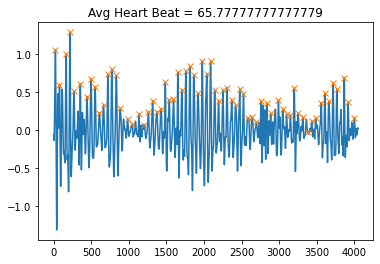

In [16]:
x_disp = outFr/2*np.arange(nyquist)/nyquist
x_disp = x_disp[1:]
distance = int(outFr/listForDistanceEstimation[PCAIndex])-5 # Emperically found realtion
peaks, _ = signal.find_peaks(chosenSignal, distance=distance)
print("Number of Peaks :: ", len(peaks))
plt.plot(chosenSignal)
plt.plot(peaks, chosenSignal[peaks], "x")
plt.title("Avg Heart Beat = "+str(listForDistanceEstimation[PCAIndex]*60))
plt.show()